In [1]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import numpy as np
import odc.geo
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import sys, os
sys.path.insert(1, os.path.abspath('../Tools'))

import rasterio
import matplotlib
import pickle
import joblib
from utils import load_data, predict_xr

In [2]:
%reload_ext autoreload
%autoreload 2

## Find and load data

Load data and set up your array to use for prediction

In [3]:
# Configure some things up front
chunks = dict(x=2048, y=2048)
datetime = "2023"

bbox = [177.142236,-17.982827, 177.590031,-17.696239]
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [4]:
merged = load_data(bbox, datetime=datetime, chunks=chunks, resolution=10)
merged

<xarray.Dataset>
Dimensions:      (y: 3332, x: 4986)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.022e+06 -2.022e+06
  * x            (x) float64 3.021e+06 3.021e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/24)
    B02          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    ...           ...
    ndmi         (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    ndbi         (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    elevation    (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    mean_vv      (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    mean_vh      (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    mean_vv_vh   (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>

In [5]:
loaded_model = joblib.load("NFI_model.dump")

In [6]:
loaded_data = merged.compute()

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


## Run ML classifier

In [7]:
filled = loaded_data.fillna(-9999.0)

In [ ]:
.sort()

In [8]:
# This runs the actual prediction
predicted = predict_xr(loaded_model, filled, proba=True)

# Convert to int
cleaned_predictions = predicted.copy(deep=True)
cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

cleaned_predictions = cleaned_predictions.rename({"predictions": "lulc", "probabilities": "prob"})

predicting...
   probabilities...


In [9]:
cleaned_predictions

<xarray.Dataset>
Dimensions:      (x: 4986, y: 3332)
Coordinates:
  * x            (x) float64 3.021e+06 3.021e+06 ... 3.071e+06 3.071e+06
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.022e+06 -2.022e+06
    spatial_ref  int32 3832
Data variables:
    lulc         (y, x) int8 6 6 6 6 6 6 6 6 6 6 6 6 ... 7 7 7 7 7 7 7 7 7 7 7 7
    prob         (y, x) float32 77.26 69.48 69.59 69.48 ... 54.13 54.13 54.14
Attributes:
    grid_mapping:  spatial_ref

In [52]:
for variable in cleaned_predictions.data_vars:
    # Extract the variable as a DataArray
    data_array = cleaned_predictions[variable]
    # Flatten the DataArray to a 1D array using numpy
    flattened_array = data_array.values.flatten()
    # Count the unique values in the flattened array
    unique_values, counts = np.unique(flattened_array, return_counts=True)
    # Create a dictionary to hold the counts of unique values
    value_counts = dict(zip(unique_values, counts))
    # Print the variable name and its value counts
    print(f"Variable: {variable}")
    print(value_counts)

Variable: lulc
{4: 274, 6: 6514045, 7: 10099033}


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



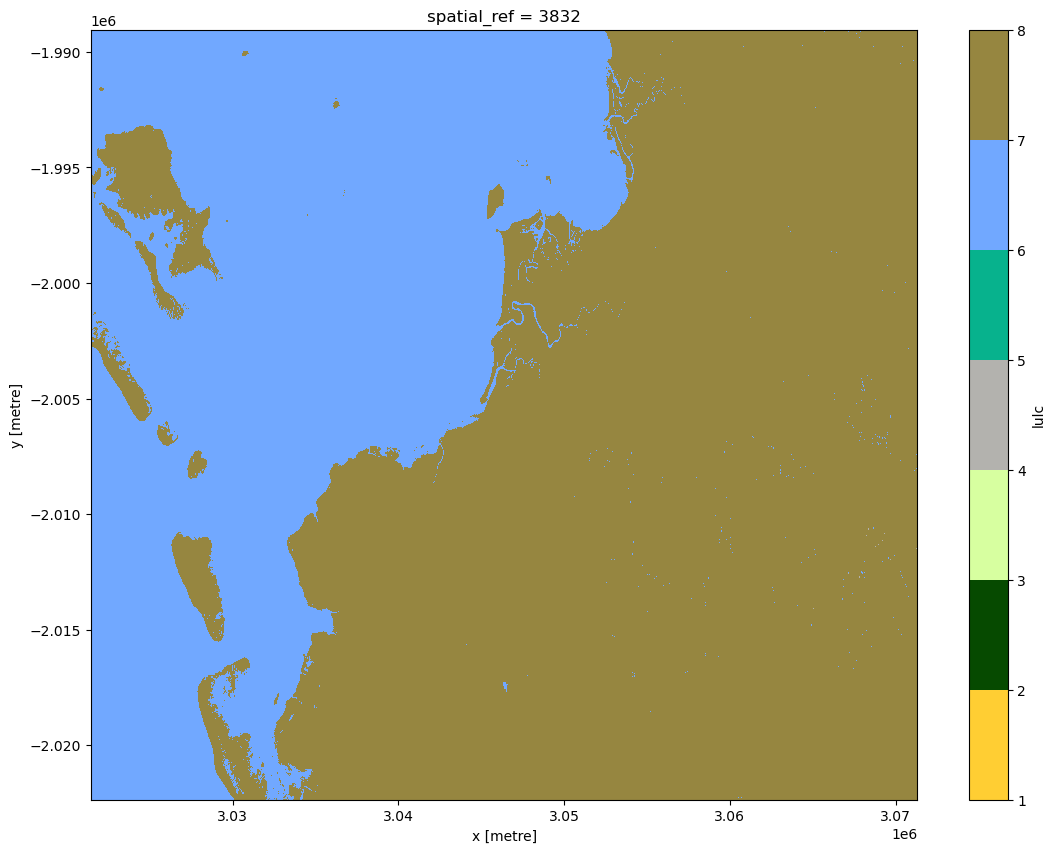

In [19]:
from matplotlib import colors

classes = [
    [1, "crops", "#ffce33"],
    [2, "forest", "#064a00"],
    [3, "grassland", "#d7ffa0"],
    [5, "settlements", "#b3b2ae"],
    [4, "mangroves", "#07b28d"],
    [6, "water", "#71a8ff"],
    [7, "bare_land", "#968640"]
]


values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Sort the values_list
values_list.sort()

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [8]
norm = colors.BoundaryNorm(bounds, c_map.N)

cleaned_predictions.lulc.plot.imshow(cmap=c_map, norm=norm, size=10)

In [25]:
# Write GeoTIFF
cleaned_predictions.lulc.odc.write_cog("lulc_2017.tif", overwrite=True)

PosixPath('lulc_2017.tif')

In [26]:
cleaned_predictions

<xarray.Dataset>
Dimensions:      (x: 4986, y: 3332)
Coordinates:
  * x            (x) float64 3.021e+06 3.021e+06 ... 3.071e+06 3.071e+06
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.022e+06 -2.022e+06
    spatial_ref  int32 3832
Data variables:
    lulc         (y, x) int8 6 6 6 6 6 6 6 6 6 6 6 6 ... 7 7 7 7 7 7 7 7 7 7 7 7
    prob         (y, x) float32 78.81 80.35 78.81 78.81 ... 60.55 60.89 59.01
Attributes:
    grid_mapping:  spatial_ref

In [54]:
quarry_2017 = cleaned_predictions.lulc.isin([8])
quarry_2017 = quarry_2017.astype(np.int32)
quarry_2017.odc.write_cog("Test_change_detection/quarry_2017.tif", overwrite=True)
bareland_2017 = cleaned_predictions.lulc.isin([1])
bareland_2017 = bareland_2017.astype(np.int32)
bareland_2017.odc.write_cog("Test_change_detection/bareland_2017.tif", overwrite=True)

PosixPath('Test_change_detection/bareland_2017.tif')

In [55]:
quarry_2017 = xr.open_dataset("Test_change_detection/quarry_2017.tif")
bareland_2017 = xr.open_dataset("Test_change_detection/bareland_2017.tif")

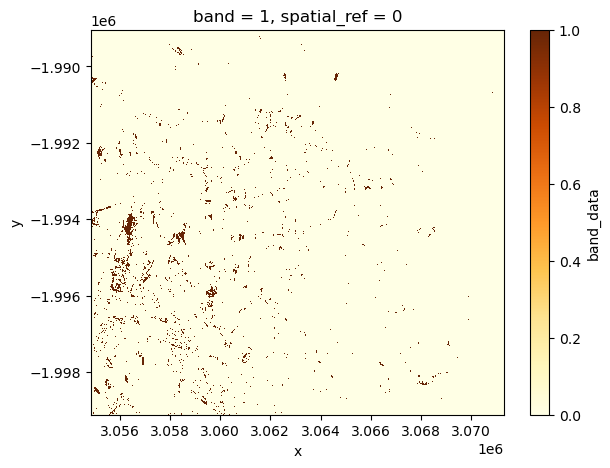

In [56]:
quarry_2017.band_data.plot(cmap="YlOrBr", size=5)

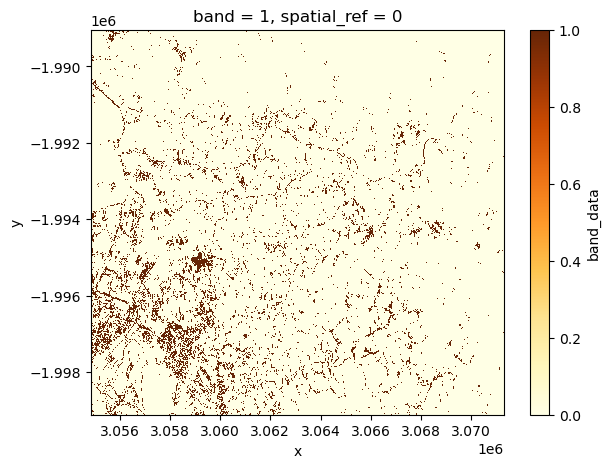

In [58]:
bareland_2017.band_data.plot(cmap="YlOrBr", size=5)

In [59]:
print("Finished")

Finished


End of notebook